In [34]:
import numpy as np
# import scipy.integrate as integrate
import scipy.stats as scs
from math import *
import matplotlib.pyplot as plt

In [11]:
a=np.arange(4)
np.random.shuffle(a)
a

array([3, 0, 2, 1])

In [174]:
def initiate(k: int, X_1:np.ndarray,X_2: np.ndarray,S: np.ndarray):
    mu_1 = np.random.normal(np.mean(X_1),np.std(X_1)**2*2,size=k)
    mu_2 = np.random.normal(np.mean(X_2),np.std(X_2)**2*2,size=k)
    tau_1 = np.ones(k)
    tau_2 = np.ones(k)
    lambd = np.abs(np.random.normal(np.mean(S),np.std(S),k))
    pi = np.ones(k)/k
    return mu_1,mu_2,tau_1,tau_2,lambd,pi

def A_computation(n: int, K: int,X_1: np.ndarray,X_2: np.ndarray, S: np.ndarray, previous_mu_1: np.ndarray,previous_mu_2: np.ndarray,previous_tau_1: np.ndarray,previous_tau_2: np.ndarray,previous_lambda: np.ndarray,previous_pi: np.ndarray):
    A= np.zeros(K)
    for k in range(K):
        p_X_1 = scs.norm(previous_mu_1[k],1/previous_tau_1[k]).pdf(X_1[n])
        p_X_2 = scs.norm(previous_mu_2[k],1/previous_tau_2[k]).pdf(X_2[n])
        p_S = scs.poisson(previous_lambda[k]).pmf(S[n])
        p_Z = previous_pi[k]
        A[k]=p_X_1*p_X_2*p_S*p_Z
        if(np.isnan(A[k])):
            print(p_X_1,p_X_2,p_S,p_Z)
            print(previous_mu_1[k],previous_tau_1[k],previous_mu_2[k],previous_tau_2[k],previous_lambda[k],previous_pi[k])
    # print(A)
    return A/np.sum(A) #normalize

def Compare(previous_mu_1: np.ndarray,previous_mu_2: np.ndarray,previous_tau_1: np.ndarray,previous_tau_2: np.ndarray,previous_lambda: np.ndarray,previous_pi: np.ndarray,mu_1: np.ndarray,mu_2: np.ndarray,tau_1: np.ndarray,tau_2: np.ndarray,lambd: np.ndarray,pi):
    res = np.sum(np.power(previous_mu_1-mu_1,2))
    res += np.sum(np.power(previous_mu_2-mu_2,2))
    res += np.sum(np.power(previous_tau_1-tau_1,2))
    res += np.sum(np.power(previous_tau_2-tau_2,2))
    res += np.sum(np.power(previous_lambda-lambd,2))
    res += np.sum(np.power(previous_pi-pi,2))
    return res

def EM(threshold: float, K: int, X_1: np.ndarray,X_2: np.ndarray, S: np.ndarray):
    N= len(X_1)
    mu_1,mu_2,tau_1,tau_2,lambd,pi = initiate(K,X_1,X_2,S)
    previous_mu_1,previous_mu_2,previous_tau_1,previous_tau_2,previous_lambda,previous_pi = mu_1+1,mu_2,tau_1*3,tau_2*3,lambd,pi*3
    loop=1
    while(Compare(previous_mu_1,previous_mu_2,previous_tau_1,previous_tau_2,previous_lambda,previous_pi,mu_1,mu_2,tau_1,tau_2,lambd,pi)>threshold):
        loop+=1
        previous_mu_1,previous_mu_2,previous_tau_1,previous_tau_2,previous_lambda,previous_pi = mu_1.copy(),mu_2.copy(),tau_1.copy(),tau_2.copy(),lambd.copy(),pi.copy()
        A = np.zeros((N,K))
        for i in range(N):
            A[i] = A_computation(i,K,X_1,X_2,S,previous_mu_1,previous_mu_2,previous_tau_1,previous_tau_2,previous_lambda,previous_pi) #expectation
        A = A.transpose()
        for k in range(K): #maximization
            if(np.sum(A[k])<1e-3):
                A[k] = A[k]/np.sum(A[k])
            pi[k]=np.sum(A[k])
            mu_1[k] = np.sum(A[k]*X_1)/np.sum(A[k])
            mu_2[k] = np.sum(A[k]*X_2)/np.sum(A[k])
            tau_1[k] = min(1e4,np.sum(A[k])/max(1e-5,np.sum(A[k]*np.power(X_1-mu_1[k],2))))
            tau_2[k] = min(1e4,np.sum(A[k])/max(1e-5,np.sum(A[k]*np.power(X_2-mu_2[k],2))))
            lambd[k] = np.sum(A[k]*S)/(np.sum(A[k]))
        pi = pi/np.sum(pi)
        # for i in range(K):
        #     print(loop,"\t",i,"\t", mu_1[i],"\t", mu_2[i],"\t", tau_1[i],"\t", tau_2[i],"\t", lambd[i],"\t",pi[i])
        # print(Compare(previous_mu_1,previous_mu_2,previous_tau_1,previous_tau_2,previous_lambda,previous_pi,mu_1,mu_2,tau_1,tau_2,lambd,pi))
    return mu_1,mu_2,tau_1,tau_2,lambd,pi

def read_files(X_file_name: str, S_file_name: str):
    X_file ="data\\"+ X_file_name
    S_file ="data\\"+ S_file_name
    with open(X_file) as file:
        X = file.readlines()
    X_1 = np.zeros(len(X))
    X_2 = np.zeros(len(X))
    for i,line in enumerate(X):
        X_1[i]=float(line.split(" ")[0])
        X_2[i]=float(line.split("\n")[0].split(" ")[1])
    with open(S_file) as file:
        S_temp = file.readlines()
    S = np.zeros(len(S_temp))
    for i,line in enumerate(S_temp):
        S[i]=float(line.split("\n")[0])
    return X_1, X_2, S


In [173]:
X_1,X_2,S = read_files("X.txt","S.txt")
mu_1,mu_2,tau_1,tau_2,lambd,pi = EM(0.1,4,X_1,X_2,S)

In [130]:
mu_1,mu_2,tau_1,tau_2,lambd,pi 

(array([0.97914204, 0.11577739, 0.32716042, 4.88636066]),
 array([0.76298895, 4.8303768 , 4.4898604 , 0.15391843]),
 array([1.14716257e+00, 2.06263782e+00, 1.00000000e+04, 2.69356541e+00]),
 array([1.01608653e+00, 1.74614942e+00, 1.00000000e+04, 2.54338428e+00]),
 array([10.12702393,  2.75102025,  4.        ,  0.26666878]),
 array([0.41103412, 0.27896838, 0.00999999, 0.29999751]))

In [134]:
X_1,X_2,S = read_files("X.txt","S.txt")
mu_1,mu_2,tau_1,tau_2,lambd,pi = EM(0.1,3,X_1,X_2,S)

In [135]:
mu_1,mu_2,tau_1,tau_2,lambd,pi

(array([4.88635963, 0.98054309, 0.12358458]),
 array([0.15391945, 0.7585155 , 4.81318427]),
 array([2.69355971, 1.14644828, 2.13384527]),
 array([2.54337926, 1.02446515, 1.76811125]),
 array([ 0.26666855, 10.1426731 ,  2.79332918]),
 array([0.2999978 , 0.41019491, 0.28980729]))

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [6]:
go.Figure(data=go.Scatter(x=X_1,y=X_2,mode="markers", marker={"color":S,'coloraxis':'coloraxis'}))

In [8]:
go.Figure(data=go.Scatter3d(x=X_1,y=X_2,z=S,mode="markers",))

In [94]:
res = np.zeros(len(X_1))-1
proba = np.zeros(len(X_1))-1
for i in range(len(X_1)):
    temp = proba_point(X_1[i],X_2[i],S[i],mu_1,mu_2,tau_1,tau_2,lambd,pi)
    proba[i] = np.sum(temp)
    res[i] = np.argmax(temp)
res

1.4393742303319791e-11
0.2999975145414036 2.7158028138314377e-21 0.00034337554519515935 1.4393742303319791e-11
0.0017514633310437345
0.28889108366947164 0.04290271506583161 1.351193753076914e-07 0.0017514633310437345
0.12346402261459637
0.4111114017891247 0.43278685565136316 0.2512957480859499 0.12346402261459637
4.857849568328593e-10
0.2999975145414036 1.0021855116044008e-21 0.07218289336543718 4.857849568328593e-10
0.005640651842676114
0.28889108366947164 0.052060704535523264 8.189374379250675e-11 0.005640651842676114
0.10974126099279935
0.4111114017891247 0.438698384552828 0.3874044575737142 0.10974126099279935
0.02723338129489682
0.2999975145414036 4.1696870552035705e-38 4.0292122090293496e-30 0.02723338129489682
0.2387449741447438
0.28889108366947164 0.8266732535518686 0.7083329697418473 0.2387449741447438
0.0020529697874618973
0.4111114017891247 0.24777339754077032 0.00012193237217760652 0.0020529697874618973
1.3220835165355126e-32
0.2999975145414036 9.513937197666715e-53 0.00016

array([2., 2., 1., 2., 1., 0., 2., 0., 1., 2., 1., 0., 2., 2., 1., 1., 0.,
       0., 1., 1., 0., 1., 2., 2., 0., 2., 2., 2., 0., 2., 1., 1., 0., 2.,
       2., 2., 1., 2., 1., 1., 2., 0., 0., 2., 1., 1., 2., 2., 1., 1., 1.,
       1., 0., 0., 2., 0., 0., 2., 1., 2., 1., 0., 2., 0., 0., 2., 0., 0.,
       2., 0., 2., 1., 2., 2., 2., 1., 2., 0., 0., 0., 2., 0., 1., 0., 1.,
       2., 0., 1., 2., 0., 2., 2., 0., 1., 2., 1., 2., 2., 2., 0.])

In [93]:
go.Figure(data=go.Scatter3d(x=X_1,y=X_2,z=S,mode="markers",marker={"color":res, 'coloraxis':'coloraxis'}),)

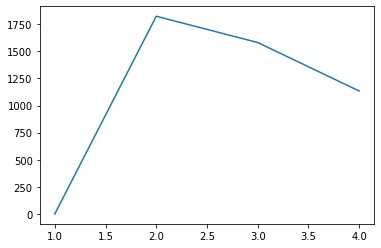

In [98]:
plt.plot(val,BIC)

In [146]:
k=3
mu_1,mu_2,tau_1,tau_2,lambd,pi = EM(0.1,k,X_1,X_2,S)
res = np.zeros(len(X_1))-1
proba_2 = np.zeros(len(X_1))-1
for i in range(len(X_1)):
    temp = proba_point(X_1[i],X_2[i],S[i],mu_1,mu_2,tau_1,tau_2,lambd,pi)
    proba_2[i] = np.sum(temp)


In [153]:
np.max(np.abs(proba_2-proba))

17497.45506776536

In [150]:
proba-proba_2

array([-2.75865260e-04, -3.28885572e-04,  4.57334032e-04, -2.07117719e-07,
        2.30691431e-05, -2.86902183e-08,  4.27920980e-06, -2.55850809e-07,
        1.13429356e-04,  3.15423245e-05,  1.62384652e-04,  1.49731404e-06,
       -1.25070463e-04, -1.56131297e-04, -2.63758448e-05,  8.97597263e-05,
       -2.69496302e-08, -6.46976035e-07,  1.30483669e-04, -1.01548661e-04,
       -1.84132890e-08, -3.00047775e-04,  2.38975900e-05, -4.86215297e-04,
       -1.44064591e-09,  3.17276391e-05, -1.25956675e-04,  1.13893946e-05,
       -8.04680095e-08, -2.24427683e-05,  4.85375671e-05, -6.29617018e-04,
       -9.12720777e-08, -3.23465792e-04, -1.35580183e-04, -2.26899243e-04,
       -1.57869960e-04, -9.28600377e-06, -3.17003381e-05,  1.12380316e-05,
        1.96138001e-05,  5.68229661e-07,  4.59602290e-07, -1.49048599e-04,
        2.07331943e-04, -2.91194784e-05, -2.83689795e-04,  1.45706560e-05,
        5.48465941e-06, -7.28760896e-05, -1.64662899e-04, -1.41326849e-04,
       -1.60002062e-08,  

In [145]:
k=4
mu_1,mu_2,tau_1,tau_2,lambd,pi = EM(0.1,k,X_1,X_2,S)
res = np.zeros(len(X_1))-1
proba = np.zeros(len(X_1))-1
for i in range(len(X_1)):
    temp = proba_point(X_1[i],X_2[i],S[i],mu_1,mu_2,tau_1,tau_2,lambd,pi)
    proba[i] = np.sum(temp)
3*k*np.log(len(X_1))- 2*np.sum(np.log(proba))

1119.1735150256384

In [111]:
- 2*np.sum(np.log(proba))

1809.8858684857094

In [108]:
3*k*np.log(len(X_1))- 2*np.sum(np.log(proba))

1134.320139036359

In [132]:
EM(0.1,3,X_1,X_2,S)

2.3152485092825376e-43
3.3530430755447704e-117
0.0


C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_8748/4248319998.py:51: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_8748/4248319998.py:52: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_8748/4248319998.py:55: RuntimeWarning:

invalid value encountered in double_scalars



(array([       nan, 0.75424192, 3.62068384]),
 array([       nan, 2.03662764, 1.32750716]),
 array([0.        , 1.18279267, 0.19454261]),
 array([0.        , 0.22933293, 0.21837568]),
 array([       nan, 8.00937866, 0.63093231]),
 array([0.        , 0.59891574, 0.40108426]))

In [179]:
min_size, zeros_size

(array([100.,  41.,  29.,   1.,   1.]), array([4., 2., 2., 2., 3.]))

1
2
3
4
5


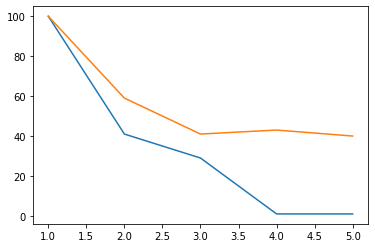

In [177]:
X_1,X_2,S = read_files("X.txt","S.txt")
val = np.arange(1,6)
BIC= np.zeros(len(val))
min_size= np.zeros(len(val))
max_size= np.zeros(len(val))
zeros_size= np.zeros(len(val))
ind_val= np.zeros(len(val))
for k in val:
    print(k)
    mu_1,mu_2,tau_1,tau_2,lambd,pi = EM(0.1,k,X_1,X_2,S)
    res = np.zeros(len(X_1))-1
    proba = np.zeros(len(X_1))-1
    for i in range(len(X_1)):
        temp = proba_point(X_1[i],X_2[i],S[i],mu_1,mu_2,tau_1,tau_2,lambd,pi)
        proba[i] = np.sum(temp)
        res[i] = np.argmax(temp)
    min_val=len(X_1)
    max_val=1
    for j in range(k):
        count = np.count_nonzero(res==j)
        if(count>max_val):
            max_val = count
        if(count<min_val):
            min_val = count
            zeros=1
        if(count==min_val):
            zeros+=1
    min_size[k-val[0]]=min_val
    max_size[k-val[0]]=max_val
    zeros_size[k-val[0]]=zeros
    BIC[k-val[0]] = 3*k*np.log(len(X_1))- 2*np.sum(np.log(proba))
plt.plot(val,min_size)
plt.plot(val,max_size)

In [109]:
2*np.sum(np.log(proba))

-1092.8736073624661

In [96]:
3*7*np.log(len(X_1))- 2*np.sum(np.log(proba))

1189.727443682254

In [181]:
go.Figure(data=go.Scatter(x=X_1,y=X_2,mode="markers", marker={"color":res,'coloraxis':'coloraxis','symbol':res}))

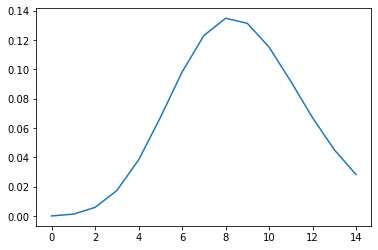

In [46]:
X=np.arange(15)
plt.plot(X,scs.poisson(mu=lambd[2]).pmf(X))

In [33]:
go.Figure(data=go.Scatter(x=X_1,y=X_2,mode="markers", marker={"color":S,'coloraxis':'coloraxis'}))